In [7]:
import pyspark as ps
import warnings
import multiprocessing
import numpy as np

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from pyspark.sql.functions import UserDefinedFunction, udf, monotonically_increasing_id
from pyspark.sql.functions import count, collect_list, split
from pyspark.sql.types import StringType, ArrayType, DoubleType

from pyspark.ml.feature import CountVectorizer, Normalizer, IDF, Tokenizer

In [8]:
# multiprocessing.cpu_count() 
try:
    sc = ps.SparkContext('local[8]')
    print "Just created a SparkContext"
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [9]:
sqlContext = ps.SQLContext(sc)

In [10]:
df = sqlContext.read.json('reviews_1000.json')

In [13]:
df.take(1)

[Row(_id=Row($oid=u'58a53c8ad24b5829f1e24b6d'), abv=u'?', avg_rating=u'4.4', ba_score=5.0, beer_name=u'Sweet Vanilla Oatmeal Stout', beer_style=u'Oatmeal Stout', brewery_name=u'10K Brewing', bros=u'-', feel=u'5', look=u'5', num_ratings=u'4', overall=u'5', smell=u'5', state=u'Minnesota', taste=u'5', text=u"Delicious vanilla smooth stout. Rumour has it this beer has just recently gone on Nitro, and I will be stopping in soon to try it. I'm sure it will be even more silky and  chocolate-vanilla tasting!\xa0198 charactersRyleeLogan, Apr 02, 2016", weighted_ba_score=u'-')]

In [106]:
def preprocess_review_text(text):
    stopwords_ = set(stopwords.words('english') + [str(i) for i in xrange(100)])
    stemmer_ = SnowballStemmer('english')
    
    if (text == None):
        return []
    
    if (len(text) < 1):
        return []
    
    if (type(text) == unicode):
        text = text.encode('utf-8')
        
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    unpunctuated_text = text.translate(replace_punctuation)
    tokens = word_tokenize(unpunctuated_text)[:-5:] # reviewer username info lost here via array slice
    lowercased_tokens = [token.lower() for token in tokens]
    filtered_tokens = [w for w in lowercased_tokens if not w in stopwords_] 
    
    stemmed = []
    for token in filtered_tokens:
        try:
            stemmed.append(stemmer_.stem(token))
        except:
            # continue when stemmer doesn't work
            continue

    return stemmed

In [107]:
token_udf = udf(lambda x: preprocess_review_text(x), ArrayType(StringType()))

df_reviews = df.select('brewery_name', 'beer_name', 'state', 'beer_style', 'text')
df_reviews.take(1)

[Row(brewery_name=u'10K Brewing', beer_name=u'Sweet Vanilla Oatmeal Stout', state=u'Minnesota', beer_style=u'Oatmeal Stout', text=u"Delicious vanilla smooth stout. Rumour has it this beer has just recently gone on Nitro, and I will be stopping in soon to try it. I'm sure it will be even more silky and  chocolate-vanilla tasting!\xa0198 charactersRyleeLogan, Apr 02, 2016")]

In [108]:
df_tokens = df_reviews.withColumn("tokens", token_udf('text'))

In [109]:
def get_all_tokens(tokens):
    return reduce(lambda x,y: x + y, tokens)

get_all_tokens_udf = udf(get_all_tokens, ArrayType(StringType()))

In [110]:
df_reviews_stemmed = df_tokens.groupby('brewery_name', 'beer_name', 'state', 'beer_style') \
                        .agg(get_all_tokens_udf(collect_list('tokens')) \
                        .alias('stemmed_tokens'))
    
df_reviews_stemmed.printSchema()

root
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- stemmed_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [21]:
# example user defined function
def up(text):
    return text.upper()
up_udf = udf(up, StringType())

In [ ]:
'''
BREAKKKKKK
'''

In [6]:
reviews_df = df.select('brewery_name', 'beer_name', 'state', 'beer_style', 'text')

root
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- text: string (nullable = true)



In [23]:
reviews_df.groupBy('brewery_name', 'beer_name', 'state')

In [189]:
grouped_reviews = reviews_df.groupBy('brewery_name', 'beer_name', 'state').agg(collect_list('text').alias('reviews'))
# grouped_reviews.collect()

In [187]:
def preprocess_reviews(reviews):
    stopwords_ = set(stopwords.words('english'))
    stemmer_ = SnowballStemmer('english')
    
    if (reviews == None):
        return []
    
    if (len(reviews) < 1):
        return []
    
    stemmed = []
    for text in reviews:
        if (type(text) == unicode):
            text = text.encode('utf-8')
        
        replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
        unpunctuated_text = text.translate(replace_punctuation)
        tokens = word_tokenize(unpunctuated_text)[:-5:] # reviewer username info lost here via array slice
        lowercased_tokens = [token.lower() for token in tokens]
        filtered_tokens = [w for w in lowercased_tokens if not w in stopwords_] 
        try:
            stemmed += [stemmer_.stem(w) for w in filtered_tokens]
        except:
            stemmed += [stemmer_.stem(w) for w in filtered_tokens[:-1:]] # review text is more than 999 characters
    return(stemmed)

In [123]:
test = '''Poured from a 12oz bottle ($6.99/four-pack) into a teku:\n\nAppearance: pours a bright copper-orange, with a thick, fluffy head. The body isn't quite translucent, but I wouldn't call it hazy either....somewhere in between. Leaves tons of sticky lacing.\n\nSmell: disappointed in this area, as I didn't get all that much from the hops. I got some dry, crackery scent from the malt, and maybe a little bit of bitterness, but the hops were a disappointment in a style that definitely needs hop aromatics.\n\nTaste: starts off with some nice, mellow fruit flavor. I got a little bit of melon, some pineapple rind.  Orange pith, not so much the flesh. Lots of bitterness, perhaps a little bit over on the bitter balance. The magnum definitely comes through on the finish much more than the El Dorado, though both give this beer a distinctly bitter flavor. Not necessarily a bad thing, but it's not the en vogue flavor right now. Nicely balanced between malt and hops.\n\nFeel: medium-bodied, with light to medium carbonation, and a semi-thick mouthfeel. Leaves a kind of dry, bitter finish.\n\nOverall: a solid first IPA from a new brewery. Combined with the fact that half of all proceeds are donated to different charities, this'll be a solid purchase, especially at the relatively cheap price point.\xa01,287 charactersTheElectricOne, Mar 25, 2016'''

reviews = [u'Solidly amber in color with just a touch of haze.  Small but lasting head which leaves decent latticed lace.\n\nVery nice blended smell of caramel malt (like an English IPA) with a pleasant floral hop (more like an East Coast US IPA).\n\nStarts mild with some toastiness on the tongue.  The hop is straight up bitterness and stronger than I expected based on the smell.  Highly carbonated and neutral in body.  Long aftertaste, but again, the flavor is straight forward.  \n\nOverall, I do like this IPA.  The interplay between the malt and hop is fun, but neither is very complex.\xa0575 characterssmcolw, Apr 22, 2016', u'Pours a slightly hazy and light amber in color with a minimal off white head that quickly faded to only a few bubbles at the edges. It has an almost murky/muddy appearance. Aroma is almost completely devoid of hop presence with a fair amount of caramelly malts. Taste is like the aroma, hop flavor is low with only hints of citrus and a few floral notes. Caramel malt character is offset by a relatively high bitterness that has a touch of astringency at the end. Medium body and moderate carbonation. Overall a very mediocre beer. I found the hop presence lacking, the caramel malts a bit heavy handed and the bitterness out of whack. I do really like the label (which is the reason that I took a chance on an unknown and picked this up).\xa0739 charactersmnj21655, Apr 19, 2016', u'A- Snifter pour from the narrow 12oz bottle with a deep orange-amber body and a foamy off-white cap that rises to just about one finger high. Head falls fairly fast to a medium ring and lacing is in sheets.\n\nS- Really not a whole lot to go by especially for the IPA style. A hint of orange citrus hops is trumped by medium caramelized malts and yeast bread notes. A bit toasty.\n\nT- Fairly malty focus carries over from the aroma with cereal grains, toast, pale caramel and raw base malt notes coming out. Hops are more present in the finish with a heavy spicy and earthy presence as well citrus, herbal tea and floral hints.\n\nMF- Texture falls somewhere between silky, frothy and a tad creamy in a medium body that leans just towards the light end. Carbonation is moderate and the finish contains an herbal bitterness.\n\nA moderate malt presence interferes with the brightness of the hops in a fairly forgettable brew in an ultra competitive style. IPAs can be balanced but this one does not excel at that.\xa01,005 characterscbutova, Mar 30, 2016', u"Poured from a 12oz bottle ($6.99/four-pack) into a teku:\n\nAppearance: pours a bright copper-orange, with a thick, fluffy head. The body isn't quite translucent, but I wouldn't call it hazy either....somewhere in between. Leaves tons of sticky lacing.\n\nSmell: disappointed in this area, as I didn't get all that much from the hops. I got some dry, crackery scent from the malt, and maybe a little bit of bitterness, but the hops were a disappointment in a style that definitely needs hop aromatics.\n\nTaste: starts off with some nice, mellow fruit flavor. I got a little bit of melon, some pineapple rind.  Orange pith, not so much the flesh. Lots of bitterness, perhaps a little bit over on the bitter balance. The magnum definitely comes through on the finish much more than the El Dorado, though both give this beer a distinctly bitter flavor. Not necessarily a bad thing, but it's not the en vogue flavor right now. Nicely balanced between malt and hops.\n\nFeel: medium-bodied, with light to medium carbonation, and a semi-thick mouthfeel. Leaves a kind of dry, bitter finish.\n\nOverall: a solid first IPA from a new brewery. Combined with the fact that half of all proceeds are donated to different charities, this'll be a solid purchase, especially at the relatively cheap price point.\xa01,287 charactersTheElectricOne, Mar 25, 2016"]
# reviews

In [192]:
# preprocess_review_text(test)
tokens = preprocess_reviews(reviews)

tokenizer_udf = udf(lambda x : preprocess_reviews(x), ArrayType(StringType()))

# df_tokens = grouped_reviews.withColumn("tokens", tokenizer_udf(grouped_reviews.reviews))
# df_tokens.printSchema()

In [111]:
cv = CountVectorizer(inputCol='stemmed_tokens', outputCol='features_tf')
cv_model = cv.fit(df_reviews_stemmed)
df_features_tf = cv_model.transform(df_reviews_stemmed)

normalizer = Normalizer(inputCol='features_tf', outputCol='features_normalized')
df_features_normalized = normalizer.transform(df_features_tf)

In [112]:
idf = IDF(inputCol='features_normalized', outputCol='features')
idf_model = idf.fit(df_features_normalized)
df_features = idf_model.transform(df_features_normalized)

# TODO: add a beer_id from 0 to len(distinct beers)-1 
df_beers = df_features.select('brewery_name', 'beer_name', 'state', 'beer_style', 'features')

In [113]:
df_beers.take(8)[7]

Row(brewery_name=u'3 Stars Brewing Company', beer_name=u'Starsky & Dutch', state=u'District of Columbia', beer_style=u'Milk / Sweet Stout', features=SparseVector(4578, {0: 0.0536, 1: 0.0334, 2: 0.0557, 3: 0.0464, 4: 0.0501, 5: 0.1058, 6: 0.0714, 7: 0.0484, 8: 0.1217, 9: 0.0239, 10: 0.102, 11: 0.0512, 12: 0.1206, 13: 0.0932, 14: 0.1732, 15: 0.0223, 16: 0.0503, 17: 0.6163, 18: 0.0197, 19: 0.01, 20: 0.0317, 21: 0.0538, 22: 0.0137, 23: 0.0683, 24: 0.0265, 25: 0.1004, 26: 0.1037, 27: 0.0108, 28: 0.084, 29: 0.016, 30: 0.0706, 31: 0.0583, 32: 0.032, 35: 0.1732, 36: 0.0451, 37: 0.0313, 38: 0.0155, 40: 0.0702, 41: 0.0602, 42: 0.0932, 43: 0.0178, 44: 0.0527, 45: 0.0518, 46: 0.0551, 47: 0.0184, 48: 0.0367, 50: 0.0702, 51: 0.1184, 53: 0.0201, 54: 0.084, 56: 0.0402, 57: 0.0991, 58: 0.0216, 61: 0.0201, 62: 0.0585, 66: 0.0244, 69: 0.2163, 71: 0.0285, 75: 0.0223, 76: 0.0308, 79: 0.0244, 83: 0.0961, 84: 0.0488, 87: 0.0879, 89: 0.0854, 90: 0.0251, 92: 0.0503, 93: 0.0303, 94: 0.0511, 95: 0.028, 101: 0.02

In [114]:
top = np.argsort(df_beers.take(8)[7].features.toArray())[::-1][:20]

In [115]:
vocab = {idx: val for idx, val in enumerate(cv_model.vocabulary)}

In [116]:
[vocab[idx] for idx in top]

[u'chocol',
 u'butter',
 u'peanut',
 u'dutch',
 u'espresso',
 u'quit',
 u'qualiti',
 u'doubl',
 u'stout',
 u'coffe',
 u'unexpect',
 u'togeth',
 u'lactos',
 u'star',
 u'nice',
 u'though',
 u'like',
 u'creami',
 u'cocoa',
 u'light']

In [27]:
# df_beers.select('features').take(1)[0].features.toArray()

In [25]:
# df_beers.select('features').agg(collect_list('features')).collect()[0].

In [272]:
def sparse_vector_to_matrix(vectors):
    return reduce(lambda x, y: np.vstack((x,y)), vectors)

matrix_udf = udf(sparse_vector_to_matrix, RowMatrix)

In [288]:
df_beers.select('features').agg(matrix_udf(collect_list('features')))

DataFrame[sparse_vector_to_matrix(collect_list(features, 0, 0)): array<double>]

In [301]:
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
matrix = RowMatrix(df_beers.select('features').rdd)

In [313]:
df_beers = df_beers.withColumn('beer_id', monotonically_increasing_id())

In [321]:
# IndexedRowMatrix(df_beers.select('beer_id', 'features').rdd.map(lambda row: IndexedRow(*row)))

In [28]:
mat = np.array([x.features.toArray() for x in df_beers.rdd.toLocalIterator()])

In [30]:
mat.T.shape

(4644, 181)

In [31]:
U, s, VT = np.linalg.svd(mat.T, full_matrices=False)

In [32]:
U.shape, s.shape, VT.shape

((4644, 181), (181,), (181, 181))

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

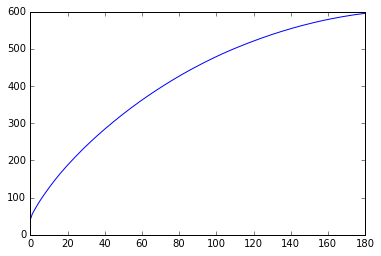

In [35]:
cumulative = np.cumsum(s ** 2)
# plt.bar(np.arange(len(cumulative)), cumulative)
plt.plot(cumulative)

In [36]:
total_energy = np.sum(s ** 2)
total_energy * .9

535.70908256512814

In [42]:
cumulative[128]

535.19382547530665

In [149]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.sparsefuncs import mean_variance_axis
import scipy.sparse as sp

U, s, VT = randomized_svd(mat.T, n_components=128)
svd = TruncatedSVD(n_components=128)
svd_model = svd.fit(mat.T)
svd_model.explained_variance_ratio_

array([ 0.05427867,  0.02452838,  0.01632689,  0.01469236,  0.01427182,
        0.01392901,  0.01294463,  0.01265193,  0.01225671,  0.01195258,
        0.01176961,  0.01154906,  0.01129013,  0.01098913,  0.0106937 ,
        0.01060054,  0.0103324 ,  0.00987094,  0.00974423,  0.00967216,
        0.00948321,  0.00927404,  0.00917706,  0.00900682,  0.00897959,
        0.00888249,  0.00873419,  0.00869181,  0.00857196,  0.00832714,
        0.0082757 ,  0.00810392,  0.00804917,  0.00800351,  0.00793632,
        0.00785305,  0.00772687,  0.00757949,  0.00753765,  0.00746007,
        0.00729531,  0.00727508,  0.00722318,  0.00714152,  0.00707458,
        0.00703644,  0.00698507,  0.00689944,  0.00685278,  0.00671853,
        0.0066637 ,  0.00661293,  0.00658121,  0.00649174,  0.0064198 ,
        0.006368  ,  0.00631957,  0.00627893,  0.00614455,  0.00611641,
        0.00604196,  0.00597222,  0.00589174,  0.00587913,  0.00583783,
        0.00574125,  0.00568448,  0.00563666,  0.00562539,  0.00

In [150]:
# https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/truncated_svd.py#L174

X_transformed = U * s
exp_var = np.var(X_transformed, axis=0)
if sp.issparse(mat.T):
    _, full_var = mean_variance_axis(mat.T, axis=0)
    full_var = full_var.sum()
else:
    full_var = np.var(mat.T, axis=0).sum()
exp_var
np.sum(exp_var / full_var)

0.89274781556555649

In [97]:
'''LSI Example'''
A = np.array([[1, 1, 1], [0, 1, 1], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 1], [1, 0, 1], [0, 2, 0], [0, 1, 1]])

In [154]:
U, s, VT = np.linalg.svd(mat.T, full_matrices=False)

In [155]:
U

array([[-0.17023584, -0.07081547,  0.0377351 , ..., -0.00777245,
         0.02402317,  0.02346556],
       [-0.12702543, -0.04657535, -0.01156605, ..., -0.02230828,
         0.04381738, -0.05284764],
       [-0.06772587, -0.02144126,  0.02002593, ...,  0.00719506,
        -0.00776556, -0.03037869],
       ..., 
       [-0.00306274, -0.00118809,  0.00076784, ...,  0.00340223,
        -0.00852569, -0.02316207],
       [-0.00362711, -0.00079017,  0.00066497, ...,  0.02680297,
         0.0015981 ,  0.01051   ],
       [-0.00362711, -0.00079017,  0.00066497, ...,  0.02680297,
         0.0015981 ,  0.01051   ]])

In [156]:
s

array([ 2.11406758,  1.81202727,  1.75115025,  1.67064058,  1.63079074,
        1.5730457 ,  1.56643667,  1.52368492,  1.46126969,  1.34835512,
        1.32846215,  1.3186198 ,  1.21757887,  1.15579583,  1.06619748,
        1.02262207,  0.97779103,  0.80334251,  0.79545702,  0.70316871])

In [157]:
VT

array([[ -1.31034164e-01,  -2.98673992e-01,  -2.90805173e-01,
         -2.99590257e-01,  -3.30708370e-01,  -2.39955648e-01,
         -8.64358557e-02,  -2.23089432e-01,  -2.06495177e-01,
         -1.83958975e-01,  -2.88292394e-01,  -1.48478563e-01,
         -3.11494745e-01,  -2.16411232e-01,  -1.25521813e-01,
         -1.71095139e-01,  -1.71032290e-01,  -1.62850869e-01,
         -2.24045383e-01,  -1.36435806e-01],
       [ -7.37246635e-02,   2.25558523e-02,  -1.16376638e-01,
         -9.96119421e-02,   1.54924300e-01,  -9.89520773e-02,
         -4.12829980e-02,  -6.61815316e-02,  -1.34074366e-01,
          5.65075823e-02,   8.70432266e-01,  -9.42078152e-02,
         -5.81640655e-02,  -9.45002216e-02,  -1.54850924e-01,
         -9.06130912e-02,  -1.29901679e-01,  -6.74226025e-02,
         -8.72017204e-02,  -2.63607177e-01],
       [  6.04239853e-02,   1.51117775e-02,   6.26616901e-02,
          6.22149462e-02,   1.14747871e-04,   2.86632431e-02,
          1.73180109e-02,   4.58174493e-02

In [158]:
U2 = U[:, :15]
U2

array([[ -1.70235845e-01,  -7.08154718e-02,   3.77351028e-02, ...,
          4.93137370e-02,  -2.06465439e-01,   3.76791518e-02],
       [ -1.27025429e-01,  -4.65753522e-02,  -1.15660496e-02, ...,
          3.23055988e-02,   3.21685462e-03,  -2.09508135e-03],
       [ -6.77258702e-02,  -2.14412634e-02,   2.00259261e-02, ...,
          1.66970852e-02,   5.51491282e-03,  -1.48232858e-02],
       ..., 
       [ -3.06273864e-03,  -1.18808578e-03,   7.67843019e-04, ...,
          2.70079351e-03,  -6.31303691e-03,   1.75060992e-03],
       [ -3.62711365e-03,  -7.90167805e-04,   6.64973256e-04, ...,
          1.04937004e-04,  -1.34630386e-03,   8.54326350e-04],
       [ -3.62711365e-03,  -7.90167805e-04,   6.64973256e-04, ...,
          1.04937004e-04,  -1.34630386e-03,   8.54326350e-04]])

In [163]:
S2 = np.diag(s)[:15, :15]
S2

array([[ 2.11406758,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.81202727,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.75115025,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.67064058,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.63079074,
         0.        ,  0.        ,  0.        , 

In [164]:
VT2 = VT[:15, :]
VT2

array([[ -1.31034164e-01,  -2.98673992e-01,  -2.90805173e-01,
         -2.99590257e-01,  -3.30708370e-01,  -2.39955648e-01,
         -8.64358557e-02,  -2.23089432e-01,  -2.06495177e-01,
         -1.83958975e-01,  -2.88292394e-01,  -1.48478563e-01,
         -3.11494745e-01,  -2.16411232e-01,  -1.25521813e-01,
         -1.71095139e-01,  -1.71032290e-01,  -1.62850869e-01,
         -2.24045383e-01,  -1.36435806e-01],
       [ -7.37246635e-02,   2.25558523e-02,  -1.16376638e-01,
         -9.96119421e-02,   1.54924300e-01,  -9.89520773e-02,
         -4.12829980e-02,  -6.61815316e-02,  -1.34074366e-01,
          5.65075823e-02,   8.70432266e-01,  -9.42078152e-02,
         -5.81640655e-02,  -9.45002216e-02,  -1.54850924e-01,
         -9.06130912e-02,  -1.29901679e-01,  -6.74226025e-02,
         -8.72017204e-02,  -2.63607177e-01],
       [  6.04239853e-02,   1.51117775e-02,   6.26616901e-02,
          6.22149462e-02,   1.14747871e-04,   2.86632431e-02,
          1.73180109e-02,   4.58174493e-02

In [105]:
qt = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [106]:
qt.dot(U2).dot(np.linalg.inv(S2))

array([-0.21400262,  0.18205705])

In [114]:
tsvd = TruncatedSVD(n_components=15)
tsvd.fit_transform(mat.T).shape

(1370, 15)

In [133]:
for i in range(0,15):
    print "component ", i
    idxs = np.argsort(tsvd.components_[i]).tolist()[::-1]
    for idx in idxs:
        print cv_model.vocabulary[idx]

component  0
pour
dark
beer
malt
head
like
tast
medium
flavor
finish
bodi
brown
light
sweet
aroma
caramel
carbon
hop
bitter
nice
component  1
like
pour
brown
malt
nice
dark
flavor
aroma
hop
medium
light
caramel
finish
tast
beer
head
sweet
bodi
bitter
carbon
component  2
carbon
like
pour
malt
aroma
nice
finish
tast
medium
flavor
dark
hop
beer
bodi
head
light
brown
caramel
sweet
bitter
component  3
bitter
like
bodi
carbon
nice
hop
caramel
beer
light
aroma
pour
dark
tast
head
malt
medium
flavor
finish
sweet
brown
component  4
brown
finish
bitter
carbon
nice
malt
aroma
tast
beer
pour
dark
flavor
light
head
hop
medium
bodi
like
caramel
sweet
component  5
finish
light
beer
aroma
tast
head
medium
like
bodi
hop
dark
flavor
nice
caramel
malt
pour
carbon
bitter
brown
sweet
component  6
sweet
finish
like
bitter
brown
caramel
carbon
medium
aroma
nice
flavor
dark
beer
hop
tast
head
light
malt
pour
bodi
component  7
caramel
nice
light
brown
like
carbon
aroma
head
bitter
beer
dark
tast
finish
flavor


In [2]:
'''testing'''
import numpy as np
c = np.array([[1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 1]])
u, s, vt = np.linalg.svd(c)